# Cell Concentrations

Data visualization of per cell concentration and voltage measurements of SISPS-EXP-SOC experiment.

[Lawrence Stanton](mailto:stnlaw003@myuct.ac.za)

## Notes and Context on Data

Following all ex-situ electronic investigation, the batteries were cut apart. Cell voltages were measured as soon as the electric nodes were available to probe. Cells were then pulled out of the plastic body. Electrode plates were cut from the parallel connection bar, deaminated, and AGM mats were extracted, squeezed and bottled. The acid samples contained significant amounts lead, visible as solids in suspension.

Batch A was done first while Batch B was performing charge cycles. Unfortunately, during this time the samples were exposed to sunlight. After a further long period of time the samples were analyzed, but by which time the lids of the sample bottles of Batch A had cracked from embrittlement. Although most samples were still effectively contained, not all were, hence a bias in the number of rejects in [Preprocessing 2](#preprocessing-2).

Concentration was measured via a density measurement using an [Anton Paar DMA 35](https://www.anton-paar.com/corp-en/products/details/portable-density-meter-dmatm-35-basic) handled density meter. The meter includes an automatic temperature compensation and sulfuric acid weight percentage calculation using built-in lookup tables, as was recorded as the measurement. Fundamentally the measurement is taken using 

## Environment

Create a python environment using the provided `environment.yml` file.

```bash
conda env create -f environment.yml
```

```{note}
Last tested using Python 3.11
```


## Defaults

In [206]:
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

import darkdetect

if darkdetect.isDark():
    plt.style.use("dark_background")

plt.rcParams.update(
    {
        "figure.dpi": 300,
        "figure.figsize": (8, 5),
    }
)

VOLTAGE_FORMATTER = plt.FuncFormatter(lambda x, _: f"{x:.2f}\u200cV")

%config InlineBackend.figure_format = 'svg'

## Data Import

In [207]:
import pandas as pd
import numpy as np
from numpy.polynomial import Polynomial

DATA_FILE = "../Data/UCT002 Cell Densities and Voltages.xlsx"

RAW_DATA = pd.read_excel(
    DATA_FILE,
    sheet_name="Sheet1",
    usecols="A:E",
    header=3,
    skipfooter=4,
)

print(RAW_DATA.head(8))
print(RAW_DATA.tail(8))

  Battery Cell  Voltage  Density (wt%)  Temperature (°C)
0     A01    I    2.189          0.423              23.6
1     NaN   II    2.184          0.428              23.6
2     NaN  III    2.176          0.426              23.3
3     NaN   IV    2.177          0.410              24.1
4     NaN    V    2.186          0.423              23.4
5     NaN   VI    2.179          0.431              23.5
6     A02    I    2.167          0.415              23.1
7     NaN   II    2.168          0.410              23.6
    Battery Cell  Voltage  Density (wt%)  Temperature (°C)
112     NaN    V    1.954          0.162              23.0
113     NaN   VI    1.949            NaN               NaN
114     B10    I    1.941            NaN               NaN
115     NaN   II    1.937          0.133              22.8
116     NaN  III    1.946          0.146              23.4
117     NaN   IV    1.943          0.158              22.6
118     NaN    V    1.945          0.158              22.4
119     NaN   V

## Preprocessing 1

In [208]:
# Fill in the missing Battery values
RAW_DATA["Battery"] = RAW_DATA["Battery"].ffill()

# Label Battery Batch and Number
RAW_DATA["Batch"] = RAW_DATA["Battery"].str[0]
RAW_DATA["Number"] = RAW_DATA["Battery"].str[1:].astype(int)

# Drop rows with NaN values
RAW_DATA = RAW_DATA.dropna()

print(RAW_DATA.head(8))
print(RAW_DATA.tail(8))

  Battery Cell  Voltage  Density (wt%)  Temperature (°C) Batch  Number
0     A01    I    2.189          0.423              23.6     A       1
1     A01   II    2.184          0.428              23.6     A       1
2     A01  III    2.176          0.426              23.3     A       1
3     A01   IV    2.177          0.410              24.1     A       1
4     A01    V    2.186          0.423              23.4     A       1
5     A01   VI    2.179          0.431              23.5     A       1
6     A02    I    2.167          0.415              23.1     A       2
7     A02   II    2.168          0.410              23.6     A       2
    Battery Cell  Voltage  Density (wt%)  Temperature (°C) Batch  Number
110     B09  III    1.949          0.149              22.5     B       9
111     B09   IV    1.958          0.169              22.8     B       9
112     B09    V    1.954          0.162              23.0     B       9
115     B10   II    1.937          0.133              22.8     B     

## Raw Data Visualization


### Scatter Plots

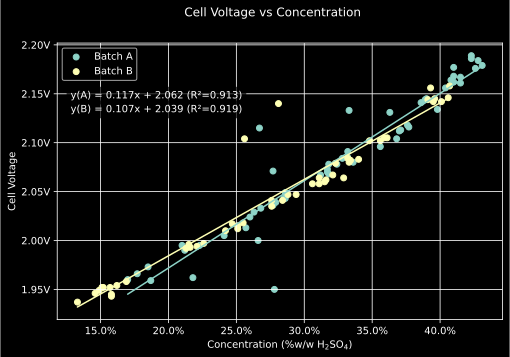

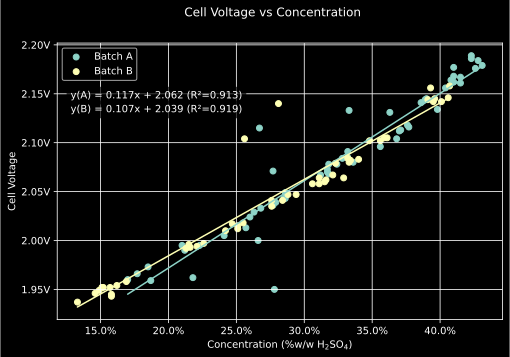

In [209]:
# Scatter plot of Voltage vs Density, grouped by Battery Batch


def plotDensityVoltageScatter(data: pd.DataFrame) -> plt.Figure:
    fig, ax = plt.subplots()
    for batch, group in data.groupby("Batch"):
        p = Polynomial.fit(group["Density (wt%)"], group["Voltage"], 1)
        a, b = p.coef[1], p.coef[0]
        r2 = np.corrcoef(group["Density (wt%)"], group["Voltage"])[0, 1] ** 2

        ax.scatter(
            group["Density (wt%)"],
            group["Voltage"],
            marker="o",
            label=f"Batch {batch}",
        )
        ax.plot(
            group["Density (wt%)"],
            p(group["Density (wt%)"]),
        )
        ax.text(
            0.03,
            0.80 if batch == "A" else 0.75,
            f"y({batch}) = {a:.3f}x + {b:.3f} (R²={r2:.3f})",
            transform=ax.transAxes,
            bbox=dict(
                facecolor="black" if darkdetect.isDark() else "white",
                alpha=0.7,
                edgecolor="none",
            ),
        )

    ax.set_xlabel(r"Concentration (%w/w H$_2$SO$_4$)")
    ax.set_ylabel("Cell Voltage")
    ax.grid(True)
    ax.xaxis.set_major_formatter(PercentFormatter(1))
    ax.yaxis.set_major_formatter(VOLTAGE_FORMATTER)
    ax.legend()
    fig.suptitle("Cell Voltage vs Concentration")

    return fig


plotDensityVoltageScatter(RAW_DATA)

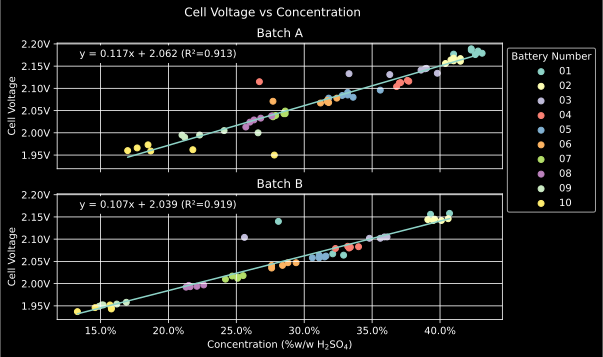

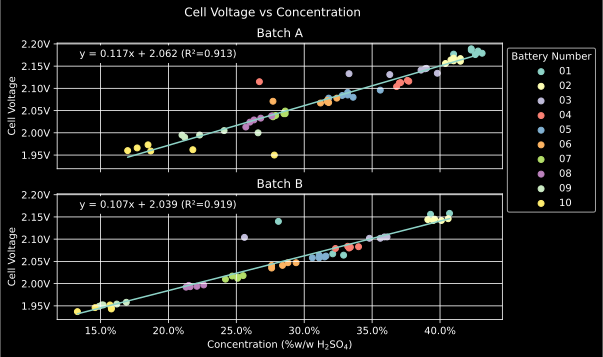

In [210]:
def plotDensityVoltageScatterByBatch(data: pd.DataFrame, **kwargs) -> plt.Figure:
    fig, ax = plt.subplots(
        2,
        1,
        sharex=True,
        sharey=True,
    )

    for batch, group in data.groupby("Batch"):
        axis = ax[0] if batch == "A" else ax[1]

        p = Polynomial.fit(group["Density (wt%)"], group["Voltage"], 1)
        a, b = p.coef[1], p.coef[0]
        r2 = np.corrcoef(group["Density (wt%)"], group["Voltage"])[0, 1] ** 2
        axis.plot(
            group["Density (wt%)"],
            p(group["Density (wt%)"]),
        )

        for number, subgroup in group.groupby("Number"):
            axis.scatter(
                subgroup["Density (wt%)"],
                subgroup["Voltage"],
                marker="o",
                label=f"{number:02d}",
            )

        # place text on the graph of polyfit
        axis.text(
            0.05,
            0.95,
            f"y = {a:.3f}x + {b:.3f} (R²={r2:.3f})",
            transform=axis.transAxes,
            verticalalignment="top",
            bbox=dict(
                facecolor="black" if darkdetect.isDark() else "white",
                alpha=1,
                edgecolor="none",
            ),
        )

        axis.set_title(f"Batch {batch}")

        axis.grid(True)
        axis.xaxis.set_major_formatter(PercentFormatter(1))
        axis.yaxis.set_major_formatter(VOLTAGE_FORMATTER)

        if batch == "B":
            axis.set_xlabel(r"Concentration (%w/w H$_2$SO$_4$)")
        axis.set_ylabel("Cell Voltage")

        if batch == "A":
            axis.legend(
                title="Battery Number",
                bbox_to_anchor=(1, 1),
            )
    fig.suptitle("Cell Voltage vs Concentration")

    return fig


plotDensityVoltageScatterByBatch(RAW_DATA)

## Preprocessing 2

It is well established by the Nernst equation that the voltage is a function of the concentration. Therefore, should a point deviate significantly in density as compared to its voltage, discard it as an outlier.

Points in this static dataset are manually selected and removed.

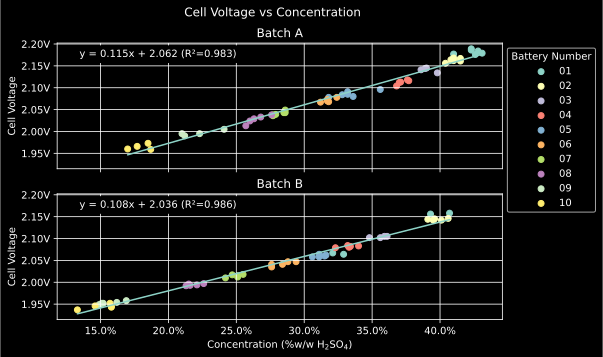

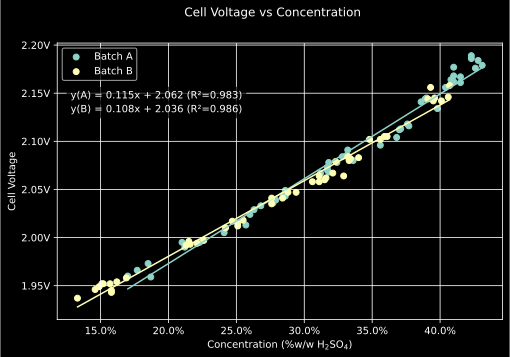

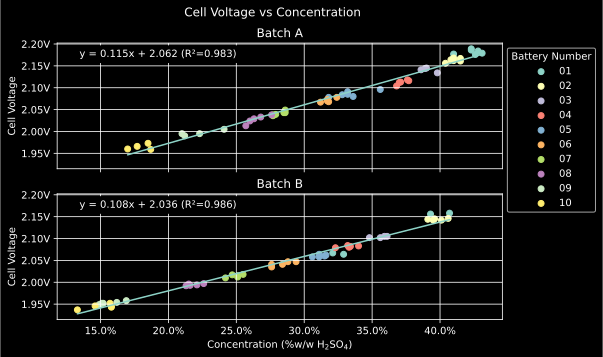

In [211]:
# Delete points inconsistent with linear density-voltage trend

KNOWN_BAD_CELLS = [
    ["A03", "I"],
    ["A03", "III"],
    ["A04", "I"],
    ["A10", "I"],
    ["A10", "IV"],
    ["A06", "VI"],
    ["A09", "I"],
    ["B01", "IV"],
    ["B03", "II"],
]

DATA = RAW_DATA.copy()
for battery, cell in KNOWN_BAD_CELLS:
    DATA = DATA[~((DATA["Battery"] == battery) & (DATA["Cell"] == cell))]

plotDensityVoltageScatter(DATA)
plotDensityVoltageScatterByBatch(DATA)